# UTD data processing & SI/AI generation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

%matplotlib inline

In [2]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision


In [3]:
# Load the final.csv data
UTD_data = pd.read_csv('./UTD-Data/UTD/final.csv')

# Extract the columns of subject;activity_number;trail and the six sensor signals
UTD_df = UTD_data.iloc[:,7:]

UTD_df

,subject,activity_number,trial,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,1,10,1,-0.951660,-0.416260,-0.091064,-18.198473,-8.671756,8.610687
1,1,10,1,-0.948486,-0.425537,-0.118652,-18.717557,-7.847328,6.442748
2,1,10,1,-0.940430,-0.426025,-0.140869,-21.404580,-5.679389,2.229008
3,1,10,1,-0.944824,-0.507568,-0.191406,-23.389313,-2.229008,-2.839695
4,1,10,1,-0.954590,-0.636963,-0.307373,-25.129771,2.137405,-6.167939
...,...,...,...,...,...,...,...,...,...
155633,8,9,4,-0.975098,-0.307861,0.120850,-4.946565,0.824427,2.748092
155634,8,9,4,-0.972412,-0.294678,0.111084,-4.152672,0.763359,1.832061
155635,8,9,4,-0.984131,-0.293701,0.111572,-2.564885,1.038168,1.496183
155636,8,9,4,-0.976318,-0.296875,0.105469,-1.709924,1.374046,1.374046


### Load data

In [4]:
# Function for generating standard type of signal data
def get_signal(file_names):
    
    out_list = []
    
    for file_name in file_names:
        
        raw_data = pd.read_csv(path + file_name)
        
        subject = re.match(r'a.*?(?=_t)',file_name).group()[-1]
        activity = re.match(r'a.*?(?=_s)',file_name).group()[1:]
        remove_subject = ['22', '23', '24', '25', '26', '27']
        
        # Ignore the activity from 22 to 27
        if activity in remove_subject:
            continue
            
        else:
            acc_x = np.array(raw_data['0']).tolist()
            acc_y = np.array(raw_data['1']).tolist()
            acc_z = np.array(raw_data['2']).tolist()
            gyro_x = np.array(raw_data['3']).tolist()
            gyro_y = np.array(raw_data['4']).tolist()
            gyro_z = np.array(raw_data['5']).tolist()

        temp_list = [subject, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, activity]
        out_list.append(temp_list)
    
    return out_list
    

In [5]:
# Get all file names of sensor data
path = './UTD-Data/UTD/csv/'
file_names = os.listdir(path)

col_label = ['Subject', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','Activity']

# Extract the activities from 1 to 21
sig_data = get_signal(file_names)
sig_data_df = pd.DataFrame(sig_data, columns=col_label)


In [6]:
sig_data_df.head()

,Subject,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Activity
0,1,"[-0.9516600000000001, -0.948486, -0.9404299999...","[-0.41626, -0.425537, -0.426025, -0.507568, -0...","[-0.09106399999999999, -0.118652, -0.140869, -...","[-18.198473, -18.717557, -21.40458, -23.389313...","[-8.671756, -7.847328, -5.679389, -2.229008000...","[8.610686999999999, 6.442748, 2.22900800000000...",10
1,1,"[-0.959717, -0.964355, -0.976807, -0.980713, -...","[-0.33129899999999995, -0.343018, -0.370117000...","[-0.11108399999999999, -0.126953, -0.140381, -...","[6.564885, 10.80916, 12.091603, 8.152672, 5.28...","[0.335878, 1.7404580000000003, 3.541985, 7.725...","[-2.80916, -3.603053, -6.10687, -9.679389, -14...",10
2,1,"[-0.954834, -0.9628909999999999, -0.962158, -0...","[-0.43335, -0.480469, -0.5014649999999999, -0....","[-0.223877, -0.280273, -0.32055700000000004, -...","[5.648855, 6.564885, 2.167939, 1.557252, 5.526...","[12.274809, 16.0, 20.702289999999998, 27.14503...","[-13.19084, -16.763359, -18.59542, -24.824427,...",10
3,1,"[-0.938232, -0.9472659999999999, -0.935059, -0...","[-0.321533, -0.32959, -0.31738299999999997, -0...","[-0.190674, -0.190186, -0.19653299999999999, -...","[-1.89313, -1.3435110000000001, -1.435115, 0.0...","[-0.396947, 0.274809, 0.8549620000000001, 1.43...","[-1.5877860000000001, -1.770992, -1.679389, -1...",10
4,2,"[-0.976318, -0.981934, -0.9855959999999999, -0...","[-0.185059, -0.18676800000000002, -0.187256, -...","[0.304199, 0.305664, 0.302246, 0.3044429999999...","[-1.7404580000000003, -1.770992, -1.770992, -1...","[1.3435110000000001, 1.282443, 1.251908, 1.374...","[-0.70229, -0.70229, -0.641221, -0.580153, -0....",10


### Jiang & Yin's method

In [8]:
def alg_2(raw_signal): ### input:raw signal list (6xNumber of sample point)
    Ns = len(raw_signal)
    sis = []
    signal_images = []
    for i in range(1,Ns+1):
        sis.append(i)
        signal_images.append(raw_signal[i-1])
    i = Ns
    j = i + 1
    Nsis = len(sis)
    while (i != j):
        inter_sis = list(zip(sis, sis[1:] + sis[:0]))
        if j > (Ns):
            j = 1
        elif (i,j) not in inter_sis and (j,i) not in inter_sis:
            sis.append(j)
            signal_images.append(raw_signal[j-1])
            Nsis += 1
            i = j
            j = i + 1
        else:
            j = j+1
    print("SIS:",sis,"NSIS:",Nsis,"(i,j):",(i,j))
    return signal_images

### New Method

In [9]:
# Algoritnm for Signal data arrangement
def order_SI(raw_sig):
    
    # According to the number of the types of sensor data
    # Generate a list of all possible pairs of each two sensor data
    type_sensor = len(raw_sig)
    pair_list = []
    
    for i in range (1,type_sensor):
        temp_list = []
        temp_list = [temp_list+[i,j+1] for j in range(i,type_sensor)]
        pair_list += temp_list
        
    # After getting all possible pairs
    # Complete the sig_list that ensure each two sensor datas are adjacent at least once
    
    # The idea is to initial the sig_list as [1,2], 
    # Then combine other possible pairs at both ends of the sig_list according to the same number
    # The priority of the combination is from long list(e.g., [1,x]) to short list(e.g., [5,x]) in pair_list
    
    # Initial the sig_list to store the arrange of each input signal vectors
    sig_list = pair_list[0]
    del pair_list[0]
    
    # Run the process until no element in pair_list
    while pair_list:
        
        for pair in pair_list:
               
            if sig_list[0] == pair[0]:
                sig_list.insert(0,pair[1])
                pair_list.remove(pair)
                break
                

            elif sig_list[0] == pair[1]:
                sig_list.insert(0,pair[0])
                pair_list.remove(pair)
                break
                

            elif sig_list[-1] == pair[0]:
                sig_list.append(pair[1])
                pair_list.remove(pair)
                break
                

            elif sig_list[-1] == pair[1]:
                sig_list.append(pair[0])
                pair_list.remove(pair)
                break
                
                
            elif pair == pair_list[-1]:
                sig_list.append(pair[0])
                sig_list.append(pair[1])
                pair_list.remove(pair)
                break
    
#     # Initial a list to store reconstructed raw data
#     sig_img = []
#     for sig_order in sig_list:
#         sig_img.append(raw_sig[sig_order-1])
    
    return sig_list


In [10]:
# Extract the six sensor data list for the first document
sig_xyz = sig_data[0][1:7]
sig_list= order_SI(sig_xyz)

# Initial a list to store reconstructed data
sig_img = []
for sig_order in sig_list:
    sig_img.append(sig_xyz[sig_order-1])

### Generate Signal Image & activity image

In [11]:
# Function for generating Image 
def make_IMG(sig_img):
    
    df_sig_image = pd.DataFrame(sig_img)
    
    # Normalize the data
    norm_df_sig_image = (df_sig_image-df_sig_image.mean())/(df_sig_image.std())
    
    # DFT process
    sig_fft = np.abs(np.fft.fft2(norm_df_sig_image))
    sig_fft_shift = np.fft.fftshift(sig_fft)
    
    img_SI = norm_df_sig_image
    img_AI = sig_fft_shift
    
    return img_SI,img_AI
    


In [12]:
img_SI,img_AI = make_IMG(sig_img)

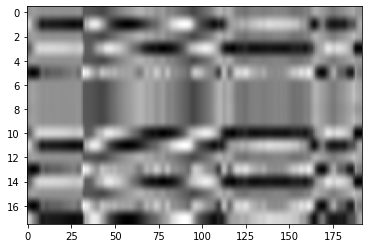

In [13]:
plt.imshow(img_SI,cmap = "gray",aspect="auto")

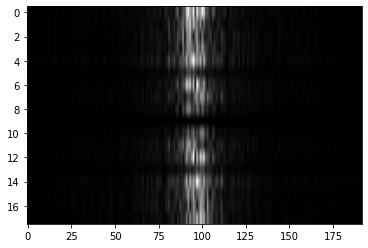

In [14]:
plt.imshow(img_AI,cmap = "gray",aspect="auto")

## CNN

In [15]:
#Two Conv & Two FC

# Define the CNN Class

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        
        self.pad_zero = nn.ZeroPad2d(1)
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.pad_zero(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

a_CNN = CNN1()

In [16]:
params = list(a_CNN.parameters())
print(len(params))
print(params[0].size())
print(params[1].size())
print(params[1])

8
torch.Size([10, 1, 3, 3])
torch.Size([10])
Parameter containing:
tensor([ 0.1783, -0.1854,  0.0042, -0.2457, -0.0337, -0.2964,  0.1281, -0.1493,
        -0.0239, -0.1982], requires_grad=True)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(a_CNN.parameters(), lr=0.001, momentum=0.9)

In [18]:
# Train Process

max_epochs=2

# Start for train time timing
torch.cuda.synchronize()
start_a = time.time()

for epoch in range(max_epochs):
    
    traindata = iter(trainloader)
    print(epoch)
    running_loss = 0.0
    i = 0
    
    for images, labels in traindata:
        
        i += 1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        
        outputs = a_CNN(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# End for train time timing
torch.cuda.synchronize()
end_a = time.time()


NameError: name 'trainloader' is not defined